**Import libraries and define system parameters**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from utils import calculate_num_sensors, calculate_graph_matrices, is_graph_connected, get_field_function, get_sensor_measurements, visualize_graphs

FIELD_SIZE = 100
FIELD_RANGE = np.array([[0, FIELD_SIZE], [0, FIELD_SIZE]]) 
field_function = get_field_function()

COMM_RANGE = 30
NUM_SENSORS = calculate_num_sensors(COMM_RANGE, FIELD_SIZE, 2)
print("Selected number of sensors:", NUM_SENSORS)

Selected number of sensors: 103


**Generate random graph**

The graph is connected.
Average temperature: 21.89 C


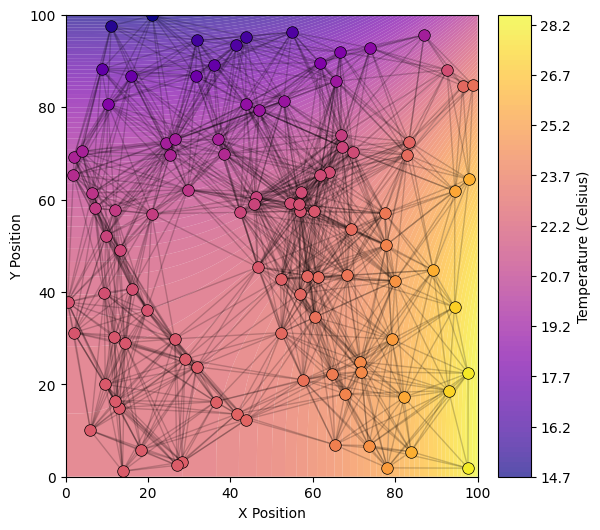

In [6]:
# Set random seed for reproducibiliy
np.random.seed(0)

# Randomly generate sensor locations within the field
sensor_locations = np.array([np.random.uniform(FIELD_RANGE[0,0], FIELD_RANGE[0,1], NUM_SENSORS),
                            np.random.uniform(FIELD_RANGE[1,0], FIELD_RANGE[1,1], NUM_SENSORS)])

# Calculate the adjacency matrix, degree matrix, and Laplacian matrix
adjacency_matrix, degree_matrix, laplacian_matrix = calculate_graph_matrices(sensor_locations, COMM_RANGE)
# Determine if the graph is connected
if not is_graph_connected(laplacian_matrix):
    print("Warning: The graph is not connected.")
else:
    print("The graph is connected.")

# Generate sensor measurements from the field function
sensor_measurements = get_sensor_measurements(sensor_locations, field_function, 0)
average_temperature = np.mean(sensor_measurements)
print("Average temperature:", "{:.2f}".format(average_temperature), "C")

# Visualize the sensor locations and the communication graph
visualize_graphs(sensor_locations, adjacency_matrix, field_function, sensor_measurements)